In [84]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

In [85]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 150)

## Population and City Name Data

In [86]:
# read the population data from Portland State University 2019 Annual Population Report Tables
# original file name was "2019 Annual Population Report Tables_A.xlsx"
pop_df = pd.read_excel("PSU_OR_2019_Population.xlsx", sheet_name = "Table 4", header = 4, nrows = 329)

In [87]:
# remove unneeded data and rename columns
pop_df.columns = pop_df.columns.astype(str)
pop_df = pop_df.drop(columns = ["2018", "2017", "2016", "2015", "2014", "2013", "2012", "2011", "2010", "2000", "1990"])
pop_df = pop_df.rename(columns = {"Years": "place", "2010rev": "2010"})

In [88]:
# define treatment group and groups to drop
medium = ["Ashland", "Canby", "Central Point", "Coos Bay", "Cottage Grove", \
           "Dallas", "Hermiston", "Klamath Falls", "La Grande", "Lebanon", "Newberg", \
           "Newport", "Ontario", "Pendleton", "Prineville", "Roseburg", "Sandy", \
           "Silverton", "St. Helens", "The Dalles"]

large_metro = ["Albany", "Beaverton", "Bend", "Clackamas", "Cornelius", \
               "Corvallis", "Durham", "Eugene", "Fairview", "Forest Grove", "Gladstone", \
               "Grants Pass", "Gresham", "Happy Valley", "Hillsboro", "Keizer", \
               "King City", "Lake Oswego", "McMinnville", "Medford", "Milwaukie", \
               "Multnomah", "Oregon City", "Portland", "Redmond", "Salem", \
               "Sherwood", "Springfield", "Tigard", "Troutdale", "Tualatin", \
               "Washington", "West Linn", "Wilsonville", "Wood Village", \
               "Woodburn"]

large_2021 = ["Albany", "Bend", "King City", "Tualatin", "Wilsonville"]

drop = ["OREGON", "BAKER", "BENTON", "CLACKAMAS", "CLATSOP", "COLUMBIA", "COOS", "CROOK", \
        "CURRY", "DESCHUTES", "DOUGLAS", "GILLIAM", "GRANT", "HARNEY", "HOOD RIVER", "JACKSON", \
        "JEFFERSON", "JOSEPHINE", "KLAMATH", "LAKE", "LANE", "LINCOLN", "LINN", "MALHEUR", \
        "MARION", "MORROW", "MULTNOMAH", "POLK", "SHERMAN", "TILLAMOOK", "UMATILLA", "UNION", \
        "WALLOWA", "WASCO", "WASHINGTON", "WHEELER", "YAMHILL", "Unincorporated", "La Pine", \
        "Hammond", "Fairview", "Grants Pass"]

keep = medium + large_metro

In [89]:
# obtain total population of cities listed in multiple counties
dup = dict()

pop_df_T = pop_df.copy().T

for ind, row in pop_df.iterrows(): 
    name = row["place"].replace(" (part)*", "")
    
    if name in dup.keys(): 
        datum = pop_df_T.pop(ind)
        orig_ind = dup[name]

        new_pop_19 = int(datum["2019"]) + int(pop_df_T.loc["2019", orig_ind])
        new_pop_10 = float(datum["2010"]) + float(pop_df_T.loc["2010", orig_ind])

        pop_df_T.loc["2019", orig_ind] = str(new_pop_19)
        pop_df_T.loc["2010", orig_ind] = str(new_pop_10)
        pop_df.loc[orig_ind, "2019"] = str(new_pop_19)
        pop_df.loc[orig_ind, "2010"] = str(new_pop_10)
    elif "(part)" in row["place"]: 
        pop_df.loc[ind, "place"] = name
        dup[name] = ind

In [90]:
# drop unneeded cities
mask = (pop_df["place"].isin(drop)) | (pop_df["place"].str.contains("\*"))
pop_df = pop_df.drop(pop_df[mask].index)

In [91]:
# recast population data type
pop_df["2019"] = pop_df["2019"].astype(str).str.replace("-", "0")
pop_df["2010"] = pop_df["2010"].astype(str).str.replace("-", "0")
pop_df["2019"] = pop_df["2019"].astype(int)
pop_df["2010"] = pop_df["2010"].astype(float).astype(int)

In [92]:
# calculate annual growth rate pct
pop_df["pop_growth"] = 0

for ind, row in pop_df.iterrows(): 
    pop_df.loc[ind, "pop_growth"] = 100 * (row["2019"] - row["2010"]) / (9 * row["2010"])

In [93]:
# of remaining cities, keep medium & large_metro and cities under 10000 people
mask = (pop_df["place"].isin(keep)) | (pop_df["2019"] < 10000)
pop_df = pop_df[mask]

In [94]:
# check that all medium cities are in data set
mask = pop_df["place"].isin(medium)
len(pop_df[mask])

20

In [95]:
# check that the large and metro cities are in the data set
mask = (pop_df["place"].isin(large_metro))
len(pop_df[mask])

31

In [96]:
# drop cities below 1000 people and above 100000 people
mask = (pop_df["2019"] < 1000) | (pop_df["2019"] > 100000)
pop_df = pop_df.drop(pop_df[mask].index)

In [97]:
# mark medium cities
mask = pop_df["place"].isin(medium)
pop_df["medium"] = 0
pop_df.loc[mask, "medium"] = 1

In [98]:
# mark large/metro cities
mask = pop_df["place"].isin(large_metro)
pop_df["large"] = 0
pop_df.loc[mask, "large"] = 1

In [99]:
# mark large/metro cities with 2021 implementations
mask = pop_df["place"].isin(large_2021)
pop_df["large21"] = 0
pop_df.loc[mask, "large21"] = 1

In [100]:
# mark control cities
mask = (pop_df["medium"] == 0) & (pop_df["large"] == 0)
pop_df["control"] = 0
pop_df.loc[mask, "control"] = 1

In [101]:
# find places to look for in outcome data
places = list(pop_df["place"])

In [102]:
mask = pop_df["control"] == 1
controls = list(pop_df.loc[mask, "place"])

In [103]:
mask = pop_df["large"] == 1
large = list(pop_df.loc[mask, "place"])

In [104]:
mask = pop_df["large21"] == 1
large21 = list(pop_df.loc[mask, "place"])

In [105]:
pop_df = pop_df.reset_index(drop = True)

In [106]:
col_names = {"2019": "pop_19", "2010": "pop_10"}

pop_df = pop_df.rename(columns = col_names)

In [461]:
# pop_df.to_csv("data_pop_post.csv")

## ACS Data

In [110]:
def clean_acs_df(df): 
    df["NAME"] = df["NAME"].str.replace(" city, Oregon", "")
    df.rename(columns = {"NAME": "place"}, inplace = True)

    return df

### 2017–2022

In [527]:
# read in ACS 2017–2022 5-year estimates data, DP05 demographic and housing characteristics from the US Census Data Profiles site
acs_dem_2022 = clean_acs_df(pd.read_csv("ACS_DP05_Dem/ACSDP5Y2022.DP05-Data.csv"))
acs_dem_2022 = acs_dem_2022.iloc[1:, :]

# variables to keep: 
# DP05_0019PE (Percent!!SEX AND AGE!!Total population!!Under 18 years)
# DP05_0079PE (Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!White alone)
# DP05_0080PE (Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Black or African American alone)
# DP05_0073PE (Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race))
to_keep = ["place", "DP05_0019PE", "DP05_0079PE", "DP05_0080PE", "DP05_0073PE"]
acs_dem_2022 = acs_dem_2022[to_keep]

acs_dem_2022 = acs_dem_2022.rename(columns = {"DP05_0019PE": "under_eighteen_2022", "DP05_0079PE": "white_2022", \
                                              "DP05_0080PE": "black_2022", "DP05_0073PE": "hisp_2022"})


to_drop = acs_dem_2022[acs_dem_2022["under_eighteen_2022"].str.contains("-")].index
acs_dem_2022 = acs_dem_2022.drop(to_drop)
acs_dem_2022["under_eighteen_2022"] = acs_dem_2022["under_eighteen_2022"].astype(float)

to_drop = acs_dem_2022[acs_dem_2022["white_2022"].str.contains("-")].index
acs_dem_2022 = acs_dem_2022.drop(to_drop)
acs_dem_2022["white_2022"] = acs_dem_2022["white_2022"].astype(float)

to_drop = acs_dem_2022[acs_dem_2022["black_2022"].str.contains("-")].index
acs_dem_2022 = acs_dem_2022.drop(to_drop)
acs_dem_2022["black_2022"] = acs_dem_2022["black_2022"].astype(float)

to_drop = acs_dem_2022[acs_dem_2022["hisp_2022"].str.contains("-")].index
acs_dem_2022 = acs_dem_2022.drop(to_drop)
acs_dem_2022["hisp_2022"] = acs_dem_2022["hisp_2022"].astype(float)

acs_dem_2022["race_other_2022"] = 100 - acs_dem_2022["white_2022"].astype(float) - acs_dem_2022["black_2022"].astype(float) - acs_dem_2022["hisp_2022"].astype(float)

In [528]:
# read in ACS 2017–2022 5-year estimates data, S1903 median income in the past 12 months in 2022 inflation-adjusted dollars
acs_inc_2022 = clean_acs_df(pd.read_csv("ACS_S1903_Inc/ACSST5Y2022.S1903-Data.csv"))
acs_inc_2022 = acs_inc_2022.iloc[1:, :]

# variables to keep: 
# S1903_C03_015E (Estimate!!Median income (dollars)!!FAMILIES!!Families)
to_keep = ["place", "S1903_C03_015E"]
acs_inc_2022 = acs_inc_2022[to_keep]

acs_inc_2022 = acs_inc_2022.rename(columns = {"S1903_C03_015E": "median_income_2022"})

to_drop = acs_inc_2022[acs_inc_2022["median_income_2022"].str.contains("-")].index
acs_inc_2022 = acs_inc_2022.drop(to_drop)
to_drop = acs_inc_2022[acs_inc_2022["median_income_2022"].str.contains("\+")].index
acs_inc_2022 = acs_inc_2022.drop(to_drop)

acs_inc_2022["median_income_2022"] = acs_inc_2022["median_income_2022"].astype(float)

In [529]:
# read in ACS 2017–2022 5-year estimates data, S2502 demographic characteristics for occupied housing units
acs_rent_2022 = clean_acs_df(pd.read_csv("ACS_S2502_Rent/ACSST5Y2022.S2502-Data.csv"))
acs_rent_2022 = acs_rent_2022.iloc[1:, :]

# variables to use: 
# S2502_C05_001E (Estimate!!Renter-occupied housing units!!Occupied housing units)
# S2502_C01_001E (Estimate!!Occupied housing units!!Occupied housing units)
acs_rent_2022["pct_renter_2022"] = 100 * acs_rent_2022["S2502_C05_001E"].astype(int) / acs_rent_2022["S2502_C01_001E"].astype(int) 

to_keep = ["place", "pct_renter_2022"]
acs_rent_2022 = acs_rent_2022[to_keep]

In [530]:
# read in ACS 2017–2022 5-year estimates data, S1501 
acs_edu_2022 = clean_acs_df(pd.read_csv("ACS_S1501_Edu/ACSST5Y2022.S1501-Data.csv"))
acs_edu_2022 = acs_edu_2022.iloc[1:, :]

# variables to keep:
# S1501_C02_015E (Estimate!!Percent!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher)
to_keep = ["place", "S1501_C02_015E"]
acs_edu_2022 = acs_edu_2022[to_keep]

acs_edu_2022 = acs_edu_2022.rename(columns = {"S1501_C02_015E": "bach_edu_2022"})

to_drop = acs_edu_2022[acs_edu_2022["bach_edu_2022"].str.contains("-")].index
acs_edu_2022 = acs_edu_2022.drop(to_drop)

acs_edu_2022["bach_edu_2022"] = acs_edu_2022["bach_edu_2022"].astype(float)

In [531]:
pop_df_2022 = pop_df.merge(acs_dem_2022, on = "place").merge(acs_inc_2022, on = "place").merge(acs_rent_2022, on = "place").merge(acs_edu_2022, on = "place")

### 2015–2020

In [117]:
# read in ACS 2015–2020 5-year estimates data, DP05 demographic and housing characteristics from the US Census Data Profiles site
acs_dem_2020 = clean_acs_df(pd.read_csv("ACS_DP05_Dem/ACSDP5Y2020.DP05-Data.csv"))
acs_dem_2020 = acs_dem_2020.iloc[1:, :]

# variables to keep: 
# DP05_0019PE (Percent!!SEX AND AGE!!Total population!!Under 18 years)
# DP05_0077PE (Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!White alone)
# DP05_0078PE (Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Black or African American alone)
# DP05_0071PE (Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race))
to_keep = ["place", "DP05_0019PE", "DP05_0077PE", "DP05_0078PE", "DP05_0071PE"]
acs_dem_2020 = acs_dem_2020[to_keep]

acs_dem_2020 = acs_dem_2020.rename(columns = {"DP05_0019PE": "under_eighteen_2020", "DP05_0077PE": "white_2020", \
                                              "DP05_0078PE": "black_2020", "DP05_0071PE": "hisp_2020"})

to_drop = acs_dem_2020[acs_dem_2020["under_eighteen_2020"].str.contains("-")].index
acs_dem_2020 = acs_dem_2020.drop(to_drop)
acs_dem_2020["under_eighteen_2020"] = acs_dem_2020["under_eighteen_2020"].astype(float)

to_drop = acs_dem_2020[acs_dem_2020["white_2020"].str.contains("-")].index
acs_dem_2020 = acs_dem_2020.drop(to_drop)
acs_dem_2020["white_2020"] = acs_dem_2020["white_2020"].astype(float)

to_drop = acs_dem_2020[acs_dem_2020["black_2020"].str.contains("-")].index
acs_dem_2020 = acs_dem_2020.drop(to_drop)
acs_dem_2020["black_2020"] = acs_dem_2020["black_2020"].astype(float)

to_drop = acs_dem_2020[acs_dem_2020["hisp_2020"].str.contains("-")].index
acs_dem_2020 = acs_dem_2020.drop(to_drop)
acs_dem_2020["hisp_2020"] = acs_dem_2020["hisp_2020"].astype(float)

acs_dem_2020["race_other_2020"] = 100 - acs_dem_2020["white_2020"].astype(float) - acs_dem_2020["black_2020"].astype(float) - acs_dem_2020["hisp_2020"].astype(float)

In [118]:
# read in ACS 2015–2020 5-year estimates data, S1903 median income in the past 12 months in 2022 inflation-adjusted dollars
acs_inc_2020 = clean_acs_df(pd.read_csv("ACS_S1903_Inc/ACSST5Y2020.S1903-Data.csv"))
acs_inc_2020 = acs_inc_2020.iloc[1:, :]

# variables to keep: 
# S1903_C03_015E (Estimate!!Median income (dollars)!!FAMILIES!!Families)
to_keep = ["place", "S1903_C03_015E"]
acs_inc_2020 = acs_inc_2020[to_keep]

acs_inc_2020 = acs_inc_2020.rename(columns = {"S1903_C03_015E": "median_income_2020"})

to_drop = acs_inc_2020[acs_inc_2020["median_income_2020"].str.contains("-")].index
acs_inc_2020 = acs_inc_2020.drop(to_drop)
to_drop = acs_inc_2020[acs_inc_2020["median_income_2020"].str.contains("\+")].index
acs_inc_2020 = acs_inc_2020.drop(to_drop)

acs_inc_2020["median_income_2020"] = acs_inc_2020["median_income_2020"].astype(float)

In [119]:
# read in ACS 2015–2020 5-year estimates data, S2502 demographic characteristics for occupied housing units
acs_rent_2020 = clean_acs_df(pd.read_csv("ACS_S2502_Rent/ACSST5Y2020.S2502-Data.csv"))
acs_rent_2020 = acs_rent_2020.iloc[1:, :]

# variables to use: 
# S2502_C05_001E (Estimate!!Renter-occupied housing units!!Occupied housing units)
# S2502_C01_001E (Estimate!!Occupied housing units!!Occupied housing units)
acs_rent_2020["pct_renter_2020"] = 100 * acs_rent_2020["S2502_C05_001E"].astype(int) / acs_rent_2020["S2502_C01_001E"].astype(int)

to_keep = ["place", "pct_renter_2020"]
acs_rent_2020 = acs_rent_2020[to_keep]

In [120]:
# read in ACS 2015–2020 5-year estimates data, S1501 
acs_edu_2020 = clean_acs_df(pd.read_csv("ACS_S1501_Edu/ACSST5Y2020.S1501-Data.csv"))
acs_edu_2020 = acs_edu_2020.iloc[1:, :]

# variables to keep:
# S1501_C02_015E (Estimate!!Percent!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher)
to_keep = ["place", "S1501_C02_015E"]
acs_edu_2020 = acs_edu_2020[to_keep]

acs_edu_2020 = acs_edu_2020.rename(columns = {"S1501_C02_015E": "bach_edu_2020"})

to_drop = acs_edu_2020[acs_edu_2020["bach_edu_2020"].str.contains("-")].index
acs_edu_2020 = acs_edu_2020.drop(to_drop)

acs_edu_2020["bach_edu_2020"] = acs_edu_2020["bach_edu_2020"].astype(float)

In [121]:
pop_df_2020 = pop_df.merge(acs_dem_2020, on = "place").merge(acs_inc_2020, on = "place").merge(acs_rent_2020, on = "place").merge(acs_edu_2020, on = "place")

In [459]:
# pop_df_2020.to_csv("data_pop_2020.csv")
# pop_df_2022.to_csv("data_pop_2022.csv")

## Plotting Demographic Data

In [123]:
pop_df["treatment"] = ""
pop_df_2020["treatment"] = ""
pop_df_2022["treatment"] = ""

for ind, row in pop_df.iterrows(): 
    if row["large"] == 1: 
        pop_df.loc[ind, "treatment"] = "Large"
    elif row["medium"] == 1: 
        pop_df.loc[ind, "treatment"] = "Medium"
    else: 
        pop_df.loc[ind, "treatment"] = "Control"

for ind, row in pop_df_2020.iterrows(): 
    if row["large"] == 1: 
        pop_df_2020.loc[ind, "treatment"] = "Large"
    elif row["medium"] == 1: 
        pop_df_2020.loc[ind, "treatment"] = "Medium"
    else: 
        pop_df_2020.loc[ind, "treatment"] = "Control"

for ind, row in pop_df_2022.iterrows(): 
    if row["large"] == 1: 
        pop_df_2022.loc[ind, "treatment"] = "Large"
    elif row["medium"] == 1: 
        pop_df_2022.loc[ind, "treatment"] = "Medium"
    else: 
        pop_df_2022.loc[ind, "treatment"] = "Control"

In [205]:
pop_df_2020["pop_bin"] = (pop_df_2020["pop_19"] // 1000) * 1000
pop_df_2022["pop_bin"] = (pop_df_2020["pop_19"] // 1000) * 1000
pop_df["pop_bin"] = (pop_df_2020["pop_19"] // 1000) * 1000

In [377]:
import matplotlib

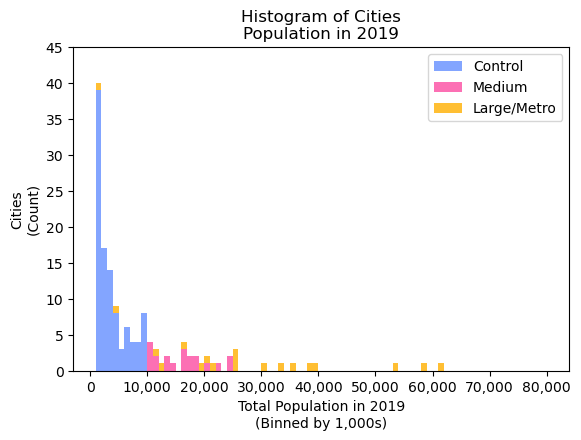

In [458]:
mask = (pop_df_2020["large21"] == 0) & (pop_df_2020["pop_19"] < 70000) & (pop_df_2020["pop_19"] > 1000)
to_plot = pop_df_2020[mask].rename(columns = {"treatment": "Treatment"})

plt.figure(figsize = [6.4, 4.2])

mask = to_plot["Treatment"] == "Control"
bot, bn, p = plt.hist(x = to_plot.loc[mask, "pop_19"], bins = list(range(1000, 70001, 1000)), color = "#648FFF", alpha = 0.8, align = "mid", label = "Control")

mask = to_plot["Treatment"] == "Medium"
bot2, bn, p = plt.hist(x = to_plot.loc[mask, "pop_19"], bottom = bot, bins = list(range(1000, 70001, 1000)), color = "#FB3395", alpha = 0.7, align = "mid", label = "Medium")

bot3 = bot + bot2
mask = to_plot["Treatment"] == "Large"
plt.hist(x = to_plot.loc[mask, "pop_19"], bottom = bot3, bins = list(range(1000, 70001, 1000)), color = "#FFB000", alpha = 0.8, align = "mid", label = "Large/Metro")

ax = plt.gca()
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.title("Histogram of Cities\nPopulation in 2019")
plt.xlabel("Total Population in 2019\n(Binned by 1,000s)")
plt.ylabel("Cities\n(Count)")
plt.legend()
plt.ylim([0, 45])
plt.show()

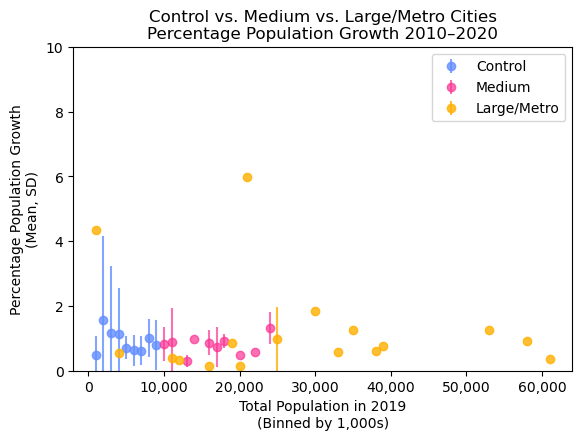

In [438]:
mask = (pop_df_2020["large21"] == 0) & (pop_df_2020["pop_19"] < 70000)
to_plot = pop_df_2020[mask].rename(columns = {"treatment": "Treatment"}).groupby(["pop_bin", "Treatment"])["pop_growth"].agg(["mean", "count", "std"]).reset_index()

plt.figure(figsize = [6.44, 4.2])

mask = to_plot["Treatment"] == "Control"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#648FFF", alpha = 0.8, label = "Control")

mask = to_plot["Treatment"] == "Medium"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#FB3395", alpha = 0.7, label = "Medium")

mask = to_plot["Treatment"] == "Large"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#FFB000", alpha = 0.8, label = "Large/Metro")

ax = plt.gca()
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.ylim([0, 10])
plt.title("Control vs. Medium vs. Large/Metro Cities\nPercentage Population Growth 2010–2020")
plt.xlabel("Total Population in 2019\n(Binned by 1,000s)")
plt.ylabel("Percentage Population Growth\n(Mean, SD)")
plt.legend()
plt.show()

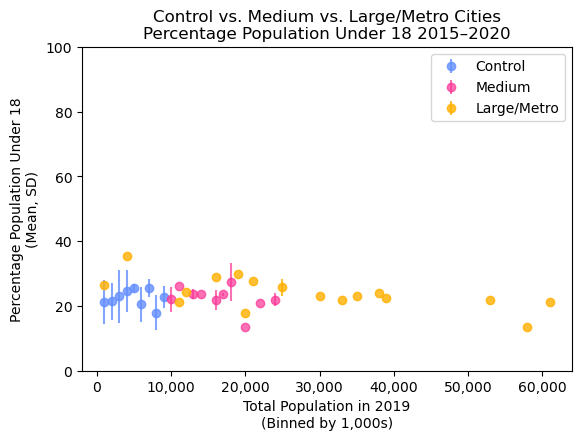

In [441]:
mask = (pop_df_2020["large21"] == 0) & (pop_df_2020["pop_19"] < 70000)
to_plot = pop_df_2020[mask].rename(columns = {"treatment": "Treatment"}).groupby(["pop_bin", "Treatment"])["under_eighteen_2020"].agg(["mean", "count", "std"]).reset_index()

plt.figure(figsize = [6.32, 4.2])

mask = to_plot["Treatment"] == "Control"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#648FFF", alpha = 0.8, label = "Control")

mask = to_plot["Treatment"] == "Medium"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#FB3395", alpha = 0.7, label = "Medium")

mask = to_plot["Treatment"] == "Large"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#FFB000", alpha = 0.8, label = "Large/Metro")

ax = plt.gca()
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.ylim([0, 100])
plt.title("Control vs. Medium vs. Large/Metro Cities\nPercentage Population Under 18 2015–2020")
plt.xlabel("Total Population in 2019\n(Binned by 1,000s)")
plt.ylabel("Percentage Population Under 18\n(Mean, SD)")
plt.legend()
plt.show()

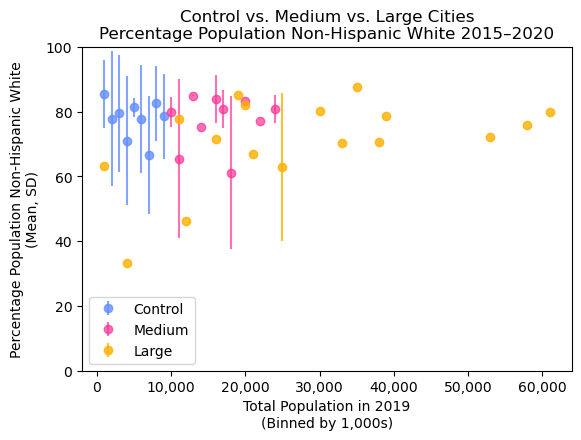

In [442]:
mask = (pop_df_2020["large21"] == 0) & (pop_df_2020["pop_19"] < 70000)
to_plot = pop_df_2020[mask].rename(columns = {"treatment": "Treatment"}).groupby(["pop_bin", "Treatment"])["white_2020"].agg(["mean", "count", "std"]).reset_index()

plt.figure(figsize = [6.32, 4.2])

mask = to_plot["Treatment"] == "Control"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#648FFF", alpha = 0.8, label = "Control")

mask = to_plot["Treatment"] == "Medium"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#FB3395", alpha = 0.7, label = "Medium")

mask = to_plot["Treatment"] == "Large"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#FFB000", alpha = 0.8, label = "Large")

ax = plt.gca()
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.ylim([0, 100])
plt.title("Control vs. Medium vs. Large Cities\nPercentage Population Non-Hispanic White 2015–2020")
plt.xlabel("Total Population in 2019\n(Binned by 1,000s)")
plt.ylabel("Percentage Population Non-Hispanic White\n(Mean, SD)")
plt.legend()
plt.show()

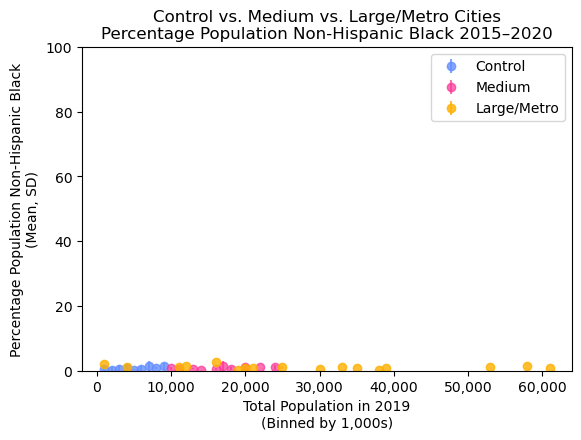

In [443]:
mask = (pop_df_2020["large21"] == 0) & (pop_df_2020["pop_19"] < 70000)
to_plot = pop_df_2020[mask].rename(columns = {"treatment": "Treatment"}).groupby(["pop_bin", "Treatment"])["black_2020"].agg(["mean", "count", "std"]).reset_index()

plt.figure(figsize = [6.32, 4.2])

mask = to_plot["Treatment"] == "Control"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#648FFF", alpha = 0.8, label = "Control")

mask = to_plot["Treatment"] == "Medium"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#FB3395", alpha = 0.7, label = "Medium")

mask = to_plot["Treatment"] == "Large"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#FFB000", alpha = 0.8, label = "Large/Metro")

ax = plt.gca()
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.ylim([0, 100])
plt.title("Control vs. Medium vs. Large/Metro Cities\nPercentage Population Non-Hispanic Black 2015–2020")
plt.xlabel("Total Population in 2019\n(Binned by 1,000s)")
plt.ylabel("Percentage Population Non-Hispanic Black\n(Mean, SD)")
plt.legend()
plt.show()

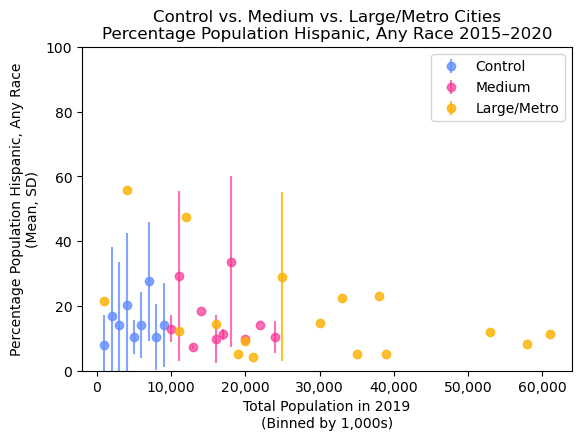

In [444]:
mask = (pop_df_2020["large21"] == 0) & (pop_df_2020["pop_19"] < 70000)
to_plot = pop_df_2020[mask].rename(columns = {"treatment": "Treatment"}).groupby(["pop_bin", "Treatment"])["hisp_2020"].agg(["mean", "count", "std"]).reset_index()

plt.figure(figsize = [6.32, 4.2])

mask = to_plot["Treatment"] == "Control"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#648FFF", alpha = 0.8, label = "Control")

mask = to_plot["Treatment"] == "Medium"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#FB3395", alpha = 0.7, label = "Medium")

mask = to_plot["Treatment"] == "Large"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#FFB000", alpha = 0.8, label = "Large/Metro")

ax = plt.gca()
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.ylim([0, 100])
plt.title("Control vs. Medium vs. Large/Metro Cities\nPercentage Population Hispanic, Any Race 2015–2020")
plt.xlabel("Total Population in 2019\n(Binned by 1,000s)")
plt.ylabel("Percentage Population Hispanic, Any Race\n(Mean, SD)")
plt.legend()
plt.show()

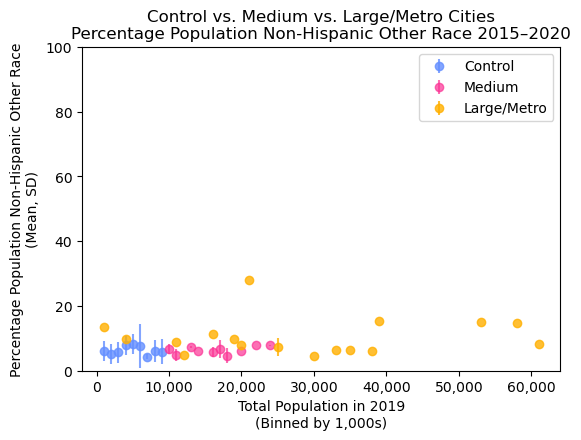

In [448]:
mask = (pop_df_2020["large21"] == 0) & (pop_df_2020["pop_19"] < 70000)
to_plot = pop_df_2020[mask].rename(columns = {"treatment": "Treatment"}).groupby(["pop_bin", "Treatment"])["race_other_2020"].agg(["mean", "count", "std"]).reset_index()

plt.figure(figsize = [6.17, 4.2])

mask = to_plot["Treatment"] == "Control"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#648FFF", alpha = 0.8, label = "Control")

mask = to_plot["Treatment"] == "Medium"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#FB3395", alpha = 0.7, label = "Medium")

mask = to_plot["Treatment"] == "Large"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#FFB000", alpha = 0.8, label = "Large/Metro")

ax = plt.gca()
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.ylim([0, 100])
plt.title("Control vs. Medium vs. Large/Metro Cities\nPercentage Population Non-Hispanic Other Race 2015–2020")
plt.xlabel("Total Population in 2019\n(Binned by 1,000s)")
plt.ylabel("Percentage Population Non-Hispanic Other Race\n(Mean, SD)")
plt.legend()
plt.show()

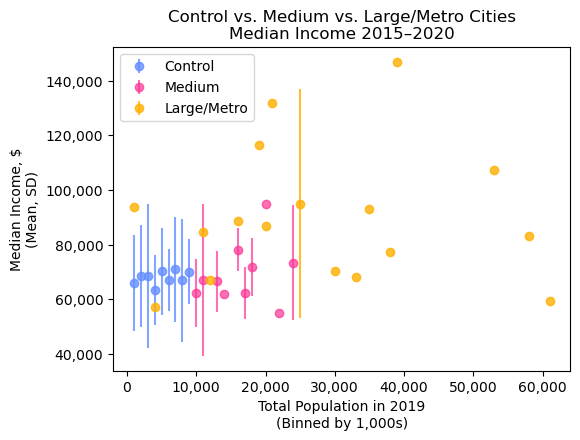

In [451]:
mask = (pop_df_2020["large21"] == 0) & (pop_df_2020["pop_19"] < 70000)
to_plot = pop_df_2020[mask].rename(columns = {"treatment": "Treatment"}).groupby(["pop_bin", "Treatment"])["median_income_2020"].agg(["mean", "count", "std"]).reset_index()

plt.figure(figsize = [5.9, 4.2])

mask = to_plot["Treatment"] == "Control"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#648FFF", alpha = 0.8, label = "Control")

mask = to_plot["Treatment"] == "Medium"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#FB3395", alpha = 0.7, label = "Medium")

mask = to_plot["Treatment"] == "Large"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#FFB000", alpha = 0.8, label = "Large/Metro")

ax = plt.gca()
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.title("Control vs. Medium vs. Large/Metro Cities\nMedian Income 2015–2020")
plt.xlabel("Total Population in 2019\n(Binned by 1,000s)")
plt.ylabel("Median Income, $\n(Mean, SD)")
plt.legend()
plt.show()

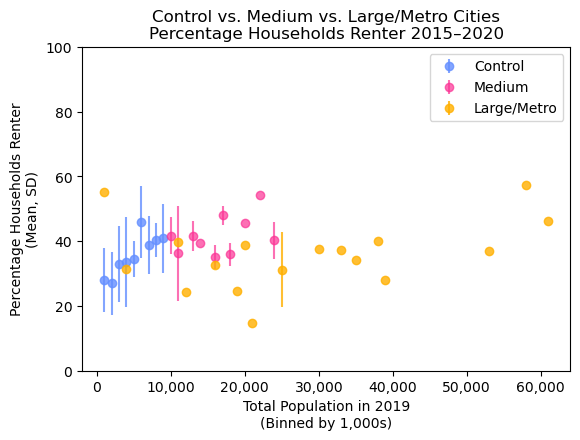

In [453]:
mask = (pop_df_2020["large21"] == 0) & (pop_df_2020["pop_19"] < 70000)
to_plot = pop_df_2020[mask].rename(columns = {"treatment": "Treatment"}).groupby(["pop_bin", "Treatment"])["pct_renter_2020"].agg(["mean", "count", "std"]).reset_index()

plt.figure(figsize = [6.3, 4.2])

mask = to_plot["Treatment"] == "Control"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#648FFF", alpha = 0.8, label = "Control")

mask = to_plot["Treatment"] == "Medium"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#FB3395", alpha = 0.7, label = "Medium")

mask = to_plot["Treatment"] == "Large"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#FFB000", alpha = 0.8, label = "Large/Metro")

ax = plt.gca()
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.ylim([0, 100])
plt.title("Control vs. Medium vs. Large/Metro Cities\nPercentage Households Renter 2015–2020")
plt.xlabel("Total Population in 2019\n(Binned by 1,000s)")
plt.ylabel("Percentage Households Renter\n(Mean, SD)")
plt.legend()
plt.show()

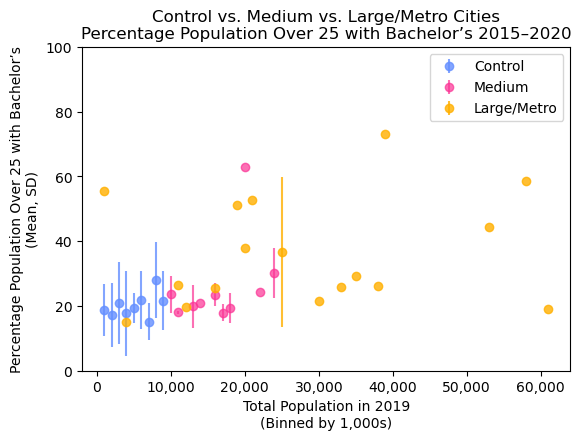

In [454]:
mask = (pop_df_2020["large21"] == 0) & (pop_df_2020["pop_19"] < 70000)
to_plot = pop_df_2020[mask].rename(columns = {"treatment": "Treatment"}).groupby(["pop_bin", "Treatment"])["bach_edu_2020"].agg(["mean", "count", "std"]).reset_index()

plt.figure(figsize = [6.3, 4.2])

mask = to_plot["Treatment"] == "Control"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#648FFF", alpha = 0.8, label = "Control")

mask = to_plot["Treatment"] == "Medium"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#FB3395", alpha = 0.7, label = "Medium")

mask = to_plot["Treatment"] == "Large"
plt.errorbar(x = to_plot.loc[mask, "pop_bin"], y = to_plot.loc[mask, "mean"], yerr = to_plot.loc[mask, "std"], linestyle = "None", fmt = "o", color = "#FFB000", alpha = 0.8, label = "Large/Metro")

ax = plt.gca()
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.ylim([0, 100])
plt.title("Control vs. Medium vs. Large/Metro Cities\nPercentage Population Over 25 with Bachelor’s 2015–2020")
plt.xlabel("Total Population in 2019\n(Binned by 1,000s)")
plt.ylabel("Percentage Population Over 25 with Bachelor’s\n(Mean, SD)")
plt.legend()
plt.show()

## BPS Data

In [133]:
# code to clean BPS data
names = ["Survey", "State", "6-Digit", "County", "Census Place", "FIPS Place", "FIPS MCD", "Pop", "CSA", \
         "CBSA", "Footnote", "Central", "Zip", "Region", "Division", "Source", "Place"]

ind_name = names + ["1_unit_bldgs", "1_unit_units", "1_unit_value", "2_unit_bldgs", "2_unit_units", "2_unit_value", \
                    "3_4_unit_bldgs", "3_4_unit_units", "3_4_unit_value", "5_unit_bldgs", "5_unit_units", "5_unit_value", \
                    "r1_unit_bldgs", "r1_unit_units", "r1_unit_value", "r2_unit_bldgs", "r2_unit_units", "r2_unit_value", \
                    "r3_4_unit_bldgs", "r3_4_unit_units", "r3_4_unit_value", "r5_unit_bldgs", "r5_unit_units", "r5_unit_value"]

col_keep = ["Survey", "Place", "1_unit_bldgs", "1_unit_units", "1_unit_value", "2_unit_bldgs", "2_unit_units", "2_unit_value", \
            "3_4_unit_bldgs", "3_4_unit_units", "3_4_unit_value", "5_unit_bldgs", "5_unit_units", "5_unit_value"]

num_cols = ["1_unit_bldgs", "1_unit_units", "1_unit_value", "2_unit_bldgs", "2_unit_units", "2_unit_value", \
            "3_4_unit_bldgs", "3_4_unit_units", "3_4_unit_value", "5_unit_bldgs", "5_unit_units", "5_unit_value"]

# function to clean yearly/monthly cumulative data
def make_y_a_df(df):
    df = df.reset_index()
    df.columns = ind_name
    
    # find oregon cities
    df = df[df["State"] == "41"]
    df = df.loc[:, col_keep]
    df["Place"] = df["Place"].str.strip()
    mask = df["Place"].isin(places)
    df = df[mask]

    # recast data type
    df = df.reset_index(drop = True)
    df[num_cols] = df.loc[:, num_cols].astype(int)

    if len(df.loc[0, "Survey"]) == 4: 
        df["Survey"] = pd.to_datetime(df.Survey, format = "%Y", errors = "ignore")
    else: 
        df["Survey"] = pd.to_datetime(df.Survey, format = "%Y12", errors = "ignore")

    # mark cities
    df["medium"] = 0
    mask = df["Place"].isin(medium)
    df.loc[mask, "medium"] = 1

    df["large"] = 0
    mask = df["Place"].isin(large)
    df.loc[mask, "large"] = 1

    df["large21"] = 0
    mask = df["Place"].isin(large21)
    df.loc[mask, "large21"] = 1

    df["control"] = 0
    mask = df["Place"].isin(controls)
    df.loc[mask, "control"] = 1

    # rename columns
    df = df.rename(columns = {"Place": "place", "Survey": "date"})
    
    # add 2019 population
    df = df.merge(pop_df[["place", "pop_19", "treatment"]], on = "place")

    # check length
    print("Total:", len(df))
    print("Medium:", len(df[df["medium"] == 1]))
    print("Large:", len(df[df["large"] == 1]))
    print("Control:", len(df[df["control"] == 1]))
    
    return df

In [134]:
df = pd.read_csv("https://www2.census.gov/econ/bps/Place/West%20Region/we2312y.txt")
df_bps_2023 = make_y_a_df(df)
mask = df_bps_2023["place"].isin(places)
in_data_2023 = list(df_bps_2023.loc[mask, "place"])

Total: 92
Medium: 15
Large: 25
Control: 52


In [135]:
df = pd.read_csv("https://www2.census.gov/econ/bps/Place/West%20Region/we2022a.txt")
df_bps_2022 = make_y_a_df(df)
mask = df_bps_2022["place"].isin(places)
in_data_2022 = list(df_bps_2022.loc[mask, "place"])

Total: 92
Medium: 15
Large: 25
Control: 52


In [136]:
df = pd.read_csv("https://www2.census.gov/econ/bps/Place/West%20Region/we2021a.txt")
df_bps_2021 = make_y_a_df(df)
mask = df_bps_2021["place"].isin(places)
in_data_2021 = list(df_bps_2021.loc[mask, "place"])

Total: 96
Medium: 17
Large: 25
Control: 54


In [137]:
df = pd.read_csv("https://www2.census.gov/econ/bps/Place/West%20Region/we2020a.txt")
df_bps_2020 = make_y_a_df(df)
mask = df_bps_2020["place"].isin(places)
in_data_2020 = list(df_bps_2020.loc[mask, "place"])

Total: 97
Medium: 17
Large: 25
Control: 55


In [138]:
df = pd.read_csv("https://www2.census.gov/econ/bps/Place/West%20Region/we2019a.txt")
df_bps_2019 = make_y_a_df(df)
mask = df_bps_2019["place"].isin(places)
in_data_2019 = list(df_bps_2019.loc[mask, "place"])

Total: 96
Medium: 16
Large: 25
Control: 55


In [139]:
df = pd.read_csv("https://www2.census.gov/econ/bps/Place/West%20Region/we2018a.txt")
df_bps_2018 = make_y_a_df(df)
mask = df_bps_2018["place"].isin(places)
in_data_2018 = list(df_bps_2018.loc[mask, "place"])

Total: 103
Medium: 16
Large: 25
Control: 62


In [140]:
df = pd.read_csv("https://www2.census.gov/econ/bps/Place/West%20Region/we2017a.txt")
df_bps_2017 = make_y_a_df(df)
mask = df_bps_2017["place"].isin(places)
in_data_2017 = list(df_bps_2017.loc[mask, "place"])

Total: 103
Medium: 16
Large: 25
Control: 62


In [141]:
# mark cities in data
mask = pop_df["place"].isin(in_data_2023)
pop_df["in_bps_2023"] = 0
pop_df.loc[mask, "in_bps_2023"] = 1

mask = pop_df["place"].isin(in_data_2022)
pop_df["in_bps_2022"] = 0
pop_df.loc[mask, "in_bps_2022"] = 1

mask = pop_df["place"].isin(in_data_2021)
pop_df["in_bps_2021"] = 0
pop_df.loc[mask, "in_bps_2021"] = 1

mask = pop_df["place"].isin(in_data_2020)
pop_df["in_bps_2020"] = 0
pop_df.loc[mask, "in_bps_2020"] = 1

mask = pop_df["place"].isin(in_data_2019)
pop_df["in_bps_2019"] = 0
pop_df.loc[mask, "in_bps_2019"] = 1

mask = pop_df["place"].isin(in_data_2018)
pop_df["in_bps_2018"] = 0
pop_df.loc[mask, "in_bps_2018"] = 1

mask = pop_df["place"].isin(in_data_2017)
pop_df["in_bps_2017"] = 0
pop_df.loc[mask, "in_bps_2017"] = 1

In [142]:
# find cities in all years
yearly_bps = ["in_bps_2023", "in_bps_2022", "in_bps_2021", "in_bps_2020", "in_bps_2019", "in_bps_2018", "in_bps_2017"]

mask = pop_df.loc[:, yearly_bps].all(axis = 1)
pop_df["in_bps_all"] = 0
pop_df.loc[mask, "in_bps_all"] = 1

mask = (pop_df["medium"] == 1) & (pop_df["in_bps_all"] == 1)
pop_df["medium_in_bps"] = 0 
pop_df.loc[mask, "medium_in_bps"] = 1

mask = (pop_df["control"] == 0) & (pop_df["in_bps_all"] == 1)
pop_df["control_in_bps"] = 0 
pop_df.loc[mask, "control_in_bps"] = 1

mask = (pop_df["large"] == 0) & (pop_df["in_bps_all"] == 1)
pop_df["large_in_bps"] = 0 
pop_df.loc[mask, "large_in_bps"] = 1

pop_df = pop_df.drop(columns = yearly_bps)

mask = pop_df["in_bps_all"] == 1
pop_df_in_bps = pop_df[mask]

In [143]:
# create panel data
balanced_panel = list(pop_df_in_bps["place"])

def make_balanced_panel(df_list): 
    final_df = pd.DataFrame()

    for df in df_list:
        mask = df["place"].isin(balanced_panel)
        to_add = df[mask]
        final_df = pd.concat([final_df, to_add]).reset_index(drop = True)
    
    return final_df

df_list = [df_bps_2017, df_bps_2018, df_bps_2019, df_bps_2020, df_bps_2021, df_bps_2022, df_bps_2023]
df_bps = make_balanced_panel(df_list)

In [144]:
# value per unit and units/bldgs per 1000 people 
df_bps_per_1000 = df_bps.copy()

cols_per_unit = ["1_unit_value", "2_unit_value", "3_4_unit_value", "5_unit_value"]

unit_cols = ["1_unit_units", "2_unit_units", "3_4_unit_units", "5_unit_units"]

cols_per_1000 = ["1_unit_bldgs", "1_unit_units", "2_unit_bldgs", "2_unit_units", "3_4_unit_bldgs", \
                 "3_4_unit_units", "5_unit_bldgs", "5_unit_units"]

for col, unit in zip(cols_per_unit, unit_cols):
    try: 
        df_bps_per_1000[col] = df_bps.apply(lambda x: x[col] / x[unit], axis = 1)
    except ZeroDivisionError:
        continue

for col in cols_per_1000:
    df_bps_per_1000[col] = df_bps.apply(lambda x: x[col] / (x["pop_19"] / 1000), axis = 1)

In [145]:
# per 1000 people for 2023, plus per 1000 people from 2020 and 2021
df_bps_2023 = pd.merge(df_bps_2023, df_bps_2021[["place", "1_unit_bldgs", "2_unit_bldgs", "3_4_unit_bldgs", "5_unit_bldgs"]].rename(columns = {"1_unit_bldgs": "one_unit_bldgs_21", "2_unit_bldgs": "two_unit_bldgs_21", "3_4_unit_bldgs": "three_unit_bldgs_21", "5_unit_bldgs": "five_unit_bldgs_21"}), on = "place")
df_bps_2023 = pd.merge(df_bps_2023, df_bps_2020[["place", "1_unit_bldgs", "2_unit_bldgs", "3_4_unit_bldgs", "5_unit_bldgs"]].rename(columns = {"1_unit_bldgs": "one_unit_bldgs_20", "2_unit_bldgs": "two_unit_bldgs_20", "3_4_unit_bldgs": "three_unit_bldgs_20", "5_unit_bldgs": "five_unit_bldgs_20"}), on = "place")

df_bps_2023_per_1000 = df_bps_2023.copy()

cols_per_unit = ["1_unit_value", "2_unit_value", "3_4_unit_value", "5_unit_value"]

unit_cols = ["1_unit_units", "2_unit_units", "3_4_unit_units", "5_unit_units"]

cols_per_1000 = ["1_unit_bldgs", "1_unit_units", "2_unit_bldgs", "2_unit_units", "3_4_unit_bldgs", \
                 "3_4_unit_units", "5_unit_bldgs", "5_unit_units", "one_unit_bldgs_21", "two_unit_bldgs_21", \
                 "three_unit_bldgs_21", "five_unit_bldgs_21"]

for col, unit in zip(cols_per_unit, unit_cols):
    try: 
        df_bps_2023_per_1000[col] = df_bps_2023.apply(lambda x: x[col] / x[unit], axis = 1)
    except ZeroDivisionError:
        continue

for col in cols_per_1000:
    df_bps_2023_per_1000[col] = df_bps_2023.apply(lambda x: x[col] / (x["pop_19"] / 1000), axis = 1)

In [493]:
# May 5: noticed above does not in fact include per 1000 people calculations for 2020
cols_per_unit = ["1_unit_value", "2_unit_value", "3_4_unit_value", "5_unit_value"]

unit_cols = ["1_unit_units", "2_unit_units", "3_4_unit_units", "5_unit_units"]

cols_per_1000 = ["one_unit_bldgs_20", "two_unit_bldgs_20", "three_unit_bldgs_20", "five_unit_bldgs_20"]

for col in cols_per_1000:
    df_bps_2023_per_1000[col] = df_bps_2023.apply(lambda x: x[col] / (x["pop_19"] / 1000), axis = 1)


In [146]:
# rename columns
col_names = {"1_unit_bldgs": "one_unit_bldgs", "1_unit_units": "one_unit_units", "1_unit_value": "one_unit_value", \
             "2_unit_bldgs": "two_unit_bldgs", "2_unit_units": "two_unit_units", "2_unit_value": "two_unit_value", \
             "3_4_unit_bldgs": "three_unit_bldgs", "3_4_unit_units": "three_unit_units", "3_4_unit_value": "three_unit_value", \
             "5_unit_bldgs": "five_unit_bldgs", "5_unit_units": "five_unit_units", "5_unit_value": "five_unit_value"}

df_bps_2023 = df_bps_2023.rename(columns = col_names)
df_bps_2023_per_1000 = df_bps_2023_per_1000.rename(columns = col_names)

df_bps = df_bps.rename(columns = col_names)
df_bps_per_1000 = df_bps_per_1000.rename(columns = col_names)

In [147]:
# merge demographic data with 2023 df
var_lst = ["place", "pop_growth", "under_eighteen_2022", "white_2022", "black_2022", "hisp_2022", "race_other_2022", "median_income_2022", "pct_renter_2022", "bach_edu_2022"]

df_bps_2023_per_1000 = df_bps_2023_per_1000.merge(pop_df_2022[var_lst], on = "place")
df_bps_2023 = df_bps_2023.merge(pop_df_2022[var_lst], on = "place")

In [148]:
# assign period based on date, with 2021 as 0 
df_bps["period"] = 0

for i, row in df_bps.iterrows(): 
    for j, date in enumerate(df_bps.date.unique()): 
        if row["date"] == date: 
            df_bps.loc[i, "period"] = j - 4

In [473]:
# export data
# df_bps_2023.to_csv("data_bps_2023_post.csv")
# df_bps_2023_per_1000.to_csv("data_bps_2023_per_1000_post.csv")

# df_bps.to_csv("data_bps_post.csv")
# df_bps_per_1000.to_csv("data_bps_per_1000_post.csv")

## Housing Values Data

In [532]:
# read in seasonally adjusted ZHVI data
# original file name City_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv
df_zhvi = pd.read_csv("City_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month_022024.csv")

# narrow data to oregon and January 2017–December 2023 and in population data
dates = list(df_zhvi.columns[212:296])
keep = ["RegionName"] + dates
mask = (df_zhvi["State"] == "OR") & (df_zhvi["RegionName"].isin(places))
df_zhvi = df_zhvi.loc[mask, keep]

# rename place column
df_zhvi = df_zhvi.rename(columns = {"RegionName": "place"})

# mark cities
mask = df_zhvi["place"].isin(medium)
df_zhvi["medium"] = 0
df_zhvi.loc[mask, "medium"] = 1

mask = df_zhvi["place"].isin(large)
df_zhvi["large"] = 0
df_zhvi.loc[mask, "large"] = 1

mask = df_zhvi["place"].isin(controls)
df_zhvi["control"] = 0
df_zhvi.loc[mask, "control"] = 1

# get values from last date
df_zhvi_2023 = df_zhvi.copy()[["place", "medium", "large", "control", "2023-12-31"]].reset_index(drop = True)
df_zhvi_2023 = pd.merge(df_zhvi_2023, pop_df_2022[["place", "treatment", "pop_19", "pop_growth", "under_eighteen_2022", "white_2022", "black_2022", "hisp_2022", "race_other_2022", "median_income_2022", "pct_renter_2022", "bach_edu_2022"]], on = "place")

# rename column
col_names = {"2023-12-31": "zhvi_2312"}
df_zhvi_2023 = df_zhvi_2023.rename(columns = col_names)

# prepare panel data
df_zhvi = df_zhvi.dropna().reset_index(drop = True)
df_zhvi = pd.melt(df_zhvi, id_vars = ["place", "medium", "large", "control"], var_name = "date", value_name = "zhvi")
df_zhvi = pd.merge(df_zhvi, pop_df_2022[["place", "pop_19", "treatment"]], on = "place")
df_zhvi["date"] = pd.to_datetime(df_zhvi["date"], format = "%Y-%m-%d")
df_zhvi = df_zhvi.sort_values("date").reset_index(drop = True)

In [533]:
# assign period based on date, with June 2021 as 0 
df_zhvi["period"] = 0

for i, row in df_zhvi.iterrows(): 
    for j, date in enumerate(df_zhvi.date.unique()): 
        if row["date"] == date: 
            df_zhvi.loc[i, "period"] = j - 53

In [502]:
cols = ["place", "one_unit_bldgs", "one_unit_units", "two_unit_bldgs", "two_unit_units", "three_unit_bldgs", \
                 "three_unit_units", "five_unit_bldgs", "five_unit_units", "one_unit_bldgs_21", "two_unit_bldgs_21", \
                 "three_unit_bldgs_21", "five_unit_bldgs_21", "one_unit_bldgs_20", "two_unit_bldgs_20", \
                 "three_unit_bldgs_20", "five_unit_bldgs_20", "large21"]

df_zhvi_2023 = pd.merge(df_zhvi_2023, df_bps_2023_per_1000[cols], on = "place")

In [503]:
cols = ["place", "one_unit_bldgs", "one_unit_units", "two_unit_bldgs", "two_unit_units", "three_unit_bldgs", \
                 "three_unit_units", "five_unit_bldgs", "five_unit_units", "large21"]

df_zhvi = pd.merge(df_zhvi, df_bps[cols], on = "place")

In [481]:
# export data
# df_zhvi.to_csv("data_zhvi_post.csv")
# df_zhvi_2023.to_csv("data_zhvi_2023_post.csv")